# Install HuggingFace Transformers package with the pretrained BERT models



In [ ]:
!pip install --upgrade transformers emoji datasets gensim
!pip install wget

# Import necessary packages

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import random
import torch 
import torch.nn as nn
from transformers import AutoTokenizer, BertModel

# Runtime environment setup

In [ ]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Utility functions

# Loading Twitch dataset

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from gensim.models import Word2Vec

def augment_split_ud(df, labeled_emotes, labels, bert_tokenizer, ud_embed, batch_size = 32):
    """
    input_data is a pd.DataFrame
    labeled_emotes is a pd.DataFrame
    """
    train_df, validation_df = train_test_split(df, test_size = 0.2, stratify = labels)

    # Augment training set
    has_emote = has_emote_idx(train_df, labeled_emotes)
    has_emote_msgs = train_df.loc[has_emote, ['sentiment', 'message']]
    no_emote_msgs = train_df.loc[~has_emote, ['sentiment_relevel', 'message']]
    

    emote_aug_data = replace_emotes(has_emote_msgs, labeled_emotes)
    emote_aug_data["sentiment_relevel"] = (emote_aug_data['sentiment'] + 1).astype('category')
    print(emote_aug_data[['sentiment_relevel', 'message']])

    train_df = pd.concat([no_emote_msgs, emote_aug_data[['sentiment_relevel', 'message']]], ignore_index = True)
    validation_df = validation_df[['sentiment_relevel', 'message']]

    train_df['message_uncased'] = train_df.message.str.lower()
    validation_df['message_uncased'] = validation_df.message.str.lower()
    train_ud = torch.Tensor(
        [ud_embed.get_sentence_vector(i) for i in train_df.message_uncased.tolist()]
    )
    validation_ud = torch.Tensor(
        [ud_embed.get_sentence_vector(i) for i in validation_df.message_uncased.tolist()]
    )


    # W2V
    #messages = [message.split(' ') for message in pd.concat([train_df, validation_df]).message]
    #w2v_model = Word2Vec(sentences = messages, min_count = 1, vector_size = 768, workers = 4, window = 5, sg = 1, seed = SEED) # train further when adding new prediction data
    #w2v_model.build_vocab(messages, update = True)
    #w2v_model.save("w2v_labeled.model")
    #w2v_model = Word2Vec.load("w2v_labeled.model")
    #train_w2v = torch.Tensor([w2v_model.wv[message.split(' ')].sum(axis = 0) for message in train_df.message])
    #validation_w2v = torch.Tensor([w2v_model.wv[message.split(' ')].sum(axis = 0) for message in validation_df.message])

    # set up DataLoader
    train_labels = torch.tensor(train_df.sentiment_relevel.values)
    validation_labels = torch.tensor(validation_df.sentiment_relevel.values)

    # tokenizer
    MAX_LEN = max([len(bert_tokenizer(datapoint)['input_ids']) for datapoint in (pd.concat([train_df, validation_df]).message.values)])
    ## TRAIN
    train_messages = train_df.message.values
    train_tokenized_inputs = bert_tokenizer(
        train_messages.tolist(),          # Input text
        add_special_tokens=True,  # add '[CLS]' and '[SEP]'
        padding='max_length',     # pad to a length specified by the max_length
        max_length=MAX_LEN,       # truncate all sentences longer than max_length
        return_tensors='pt',      # return everything we need as PyTorch tensors
    )
    train_inputs = train_tokenized_inputs['input_ids']
    train_masks = train_tokenized_inputs['attention_mask']
    ## VALIDATION
    validation_messages = validation_df.message.values
    validation_tokenized_inputs = bert_tokenizer(
        validation_messages.tolist(),          # Input text
        add_special_tokens=True,  # add '[CLS]' and '[SEP]'
        padding='max_length',     # pad to a length specified by the max_length
        max_length=MAX_LEN,       # truncate all sentences longer than max_length
        return_tensors='pt',      # return everything we need as PyTorch tensors
    )
    validation_inputs = validation_tokenized_inputs['input_ids']
    validation_masks = validation_tokenized_inputs['attention_mask']

    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_inputs, train_ud, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(validation_inputs, validation_ud, validation_masks, validation_labels)
    validation_dataloader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

    return train_dataloader, validation_dataloader


def train_valid_split_w2v(input_ids, input_w2v, attention_masks, labels, batch_size=32):
    """
    Create DataLoader objects for downstream training
    """
    # Use 80% for training and 20% for validation.
    train_inputs, validation_inputs, train_w2v, validation_w2v, train_masks, validation_masks, train_labels, validation_labels = train_test_split(
        input_ids, input_w2v, attention_masks, labels, random_state=SEED, test_size=0.2, stratify=labels
    )

    print('example train_input:    ', train_inputs[0])
    print('example attention_mask: ', train_masks[0])

    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)

    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_inputs, train_w2v, train_masks, train_labels)

    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(validation_inputs, validation_w2v, validation_masks, validation_labels)
    validation_dataloader = DataLoader(validation_data, shuffle = False, batch_size=batch_size)

    return train_dataloader, validation_dataloader


def train_valid_split_w2v_mlp(input_w2v, labels, batch_size=64):
    """
    Create DataLoader objects for MLP baseline
    """
    # Use 80% for training and 20% for validation.
    train_w2v, validation_w2v, train_labels, validation_labels = train_test_split(
        input_w2v, labels, random_state=SEED, test_size=0.2, stratify=labels
    )

    print('example train w2v input:    ', train_w2v[0])
    print('example label: ', train_labels[0])

    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)

    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_w2v, train_labels)

    train_dataloader = DataLoader(train_data, shuffle = True, batch_size=batch_size)

    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(validation_w2v, validation_labels)
    validation_dataloader = DataLoader(validation_data, shuffle = False, batch_size=batch_size)

    return train_dataloader, validation_dataloader


def train_valid_split_w2v_ext(input_ids, input_w2v, ext_w2v, attention_masks, labels, batch_size=32):
    """
    Create DataLoader objects for downstream training
    """
    # Use 80% for training and 20% for validation.
    train_inputs, validation_inputs, train_w2v, validation_w2v, train_ext, validation_ext, train_masks, validation_masks, train_labels, validation_labels = train_test_split(
        input_ids, input_w2v, ext_w2v, attention_masks, labels, random_state=SEED, test_size=0.2, stratify=labels
    )

    print('example train_input:    ', train_inputs[0])
    print('example attention_mask: ', train_masks[0])

    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)

    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_inputs, train_w2v, train_ext, train_masks, train_labels)

    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(validation_inputs, validation_w2v, validation_ext, validation_masks, validation_labels)
    validation_dataloader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

    return train_dataloader, validation_dataloader

def train_valid_split_ext(input_ids, input_ext, attention_masks, labels, seed, batch_size=32):
    """
    Create DataLoader objects for downstream training
    input_ext: any additional embeddings
    """
    # Use 80% for training and 20% for validation.
    train_inputs, validation_inputs, train_ext, validation_ext, train_masks, validation_masks, train_labels, validation_labels = train_test_split(
        input_ids, input_ext, attention_masks, labels, random_state=seed, test_size=0.2, stratify=labels
    )

    print('example train_input:    ', train_inputs[0])
    print('example attention_mask: ', train_masks[0])

    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)

    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_inputs, train_ext, train_masks, train_labels)

    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(validation_inputs, validation_ext, validation_masks, validation_labels)
    validation_dataloader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

    return train_dataloader, validation_dataloader


def train_valid_split(input_ids, attention_masks, labels, batch_size=32):
    # Use 80% for training and 20% for validation.
    train_inputs, validation_inputs,  train_masks, validation_masks, train_labels, validation_labels = train_test_split(
        input_ids, attention_masks, labels, random_state=SEED, test_size=0.2, stratify=labels
    )

    print('example train_input:    ', train_inputs[0])
    print('example attention_mask: ', train_masks[0])

    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)

    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_dataloader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

    return train_dataloader, validation_dataloader

# Training functions

In [ ]:
from torch.optim import AdamW
import time
import datetime
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score

def collect_flat_outputs(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return pred_flat, labels_flat
    
def flat_accuracy(preds, labels):
    pred_flat, labels_flat = collect_flat_outputs(preds, labels)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def get_optimizer_and_scheduler(model, total_steps, lr=2e-5, weight_decay=0.01):
    # Apply weight decay to all parameters beside the biases or LayerNorm weights
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': weight_decay},
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        # Warmup learning rate for first 10% of training steps
        num_warmup_steps=int(0.10 * total_steps), 
        num_training_steps=total_steps,
    )
    return optimizer, scheduler

def train_model(model, epochs, train_dataloader, validation_dataloader):
    # Use GPU, if available
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device) # TPU right now

    # Setup optimizer and LR scheduler 
    total_steps = len(train_dataloader) * epochs
    optimizer, scheduler = get_optimizer_and_scheduler(
        model, total_steps, lr = 2e-5, weight_decay = 0.1
    )

    eval_metrics = {
            'train_loss': [],
            'valid_loss': [],
            'valid_accs': [],
            'f1': [],
            'recall': [],
            'curr_max' : 0
        }

    #loss_values = []
    #eval_accs = []
    curr_max = 0 # current max eval acc

    for epoch in range(0, epochs):
        t0 = time.time()

        total_train_loss = 0
        model.train()

        # ================== ONE EPOCH TRAINING STARTS =========================
        with tqdm(train_dataloader, unit="batch") as train_pbar:
            for batch in train_pbar:
                train_pbar.set_description(f"Training (epoch {epoch + 1})")
                b_input_ids  = batch[0].to(device)
                b_input_mask = batch[-2].to(device)
                b_labels     = batch[-1].to(device)

                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # This will return the loss because we have provided the `labels`.
                if model.ext_embed_mode == 'add':
                    b_input_add_embed = batch[1].to(device)
                    outputs = model(
                        input_ids      = b_input_ids, 
                        attention_mask = b_input_mask, 
                        labels         = b_labels,
                        ext_embed_add  = b_input_add_embed
                    )
                elif model.ext_embed_mode == 'concat':
                    b_input_cat_embed = batch[1].to(device)
                    outputs = model(
                        input_ids        = b_input_ids, 
                        attention_mask   = b_input_mask, 
                        labels           = b_labels,
                        ext_embed_concat = b_input_cat_embed
                    )
                elif model.ext_embed_mode == 'both':
                    b_input_add_embed = batch[1].to(device)
                    b_input_cat_embed = batch[2].to(device)
                    outputs = model(
                        input_ids        = b_input_ids, 
                        attention_mask   = b_input_mask, 
                        labels           = b_labels,
                        ext_embed_add    = b_input_add_embed,
                        ext_embed_concat = b_input_cat_embed
                    )
                else:
                    ## No external embedding blending in
                    outputs = model(
                        input_ids      = b_input_ids, 
                        attention_mask = b_input_mask, 
                        labels         = b_labels
                    )
                
                # The call to `model` always returns a tuple, so we need to pull the 
                # loss value out of the tuple.
                _, loss = outputs

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                optimizer.step()

                # Update the learning rate.
                scheduler.step()
        # =================== ONE EPOCH TRAINING ENDS ==========================

        # Calculate the average loss over the training data.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Store the loss value for plotting the learning curve.
        eval_metrics["train_loss"].append(avg_train_loss)

        print("  * Average training loss: {0:.2f}".format(avg_train_loss))
        print("  * Training epoch took: {:}".format(format_time(time.time() - t0)))
            
        print("Running Validation...")

        t0 = time.time()
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        f1 = 0
        epoch_preds, epoch_labels = [], []

        # Evaluate data for one epoch
        # ================== ONE EPOCH VALIDATING STARTS =======================
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids  = batch[0]
            b_input_mask = batch[-2]
            b_labels     = batch[-1]
            
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # Perform a forward pass (evaluate the model on this training batch).
                # This will return the loss because we have provided the `labels`.
                if model.ext_embed_mode == 'add':
                    b_input_add_embed = batch[1]
                    outputs = model(
                        input_ids      = b_input_ids, 
                        attention_mask = b_input_mask, 
                        labels         = b_labels,
                        ext_embed_add  = b_input_add_embed
                    )
                elif model.ext_embed_mode == 'concat':
                    b_input_cat_embed = batch[1]
                    outputs = model(
                        input_ids        = b_input_ids, 
                        attention_mask   = b_input_mask, 
                        labels           = b_labels,
                        ext_embed_concat = b_input_cat_embed
                    )
                elif model.ext_embed_mode == 'both':
                    b_input_add_embed = batch[1]
                    b_input_cat_embed = batch[2]
                    outputs = model(
                        input_ids        = b_input_ids, 
                        attention_mask   = b_input_mask, 
                        labels           = b_labels,
                        ext_embed_add    = b_input_add_embed,
                        ext_embed_concat = b_input_cat_embed
                    )
                else:
                    ## No external embedding blending in
                    outputs = model(
                        input_ids      = b_input_ids, 
                        attention_mask = b_input_mask, 
                        labels         = b_labels
                    )
            
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits, loss = outputs
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            # Collect predictions and labels from each validation batch
            batch_preds, batch_labels = collect_flat_outputs(logits, label_ids)
            epoch_preds.append(batch_preds)
            epoch_labels.append(batch_labels)
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
            # Accumulate the total loss.
            eval_loss += loss.item()
            # Track the number of batches
            nb_eval_steps += 1
        # =================== ONE EPOCH VALIDATING ENDS ========================
        epoch_preds  = np.concatenate(epoch_preds)
        epoch_labels = np.concatenate(epoch_labels)
        f1 = f1_score(epoch_preds, epoch_labels, average = 'macro')
        recall = recall_score(epoch_preds, epoch_labels, average = 'macro')
        avg_eval_acc  = eval_accuracy / nb_eval_steps
        avg_eval_loss = eval_loss / nb_eval_steps ## average valid. loss over batches
        print("  * Accuracy: {0:.2f}".format(avg_eval_acc))
        print("  * Averaged validation loss: {0:.2f}".format(avg_eval_loss))
        print("  * F1 score: {0:.2f}".format(f1))
        print("  * Validation took: {:}".format(format_time(time.time() - t0)))
        eval_metrics["valid_accs"].append(avg_eval_acc)
        eval_metrics["valid_loss"].append(avg_eval_loss)
        eval_metrics['f1'].append(f1)

        print(f"PREVIOUS BEST EVAL:{curr_max}")
        # save max eval model
        if max(avg_eval_acc, curr_max) == avg_eval_acc:
          curr_max = avg_eval_acc
          eval_metrics["curr_max"] = curr_max
          try:
            os.makedirs("./weights/")
          except:
            print("dir exists")
          print("Saving Weights...")
          model.save_pretrained("./weights/curr")

    print("Training complete!")
    return eval_metrics

## Download Twitch data

In [ ]:
!pip install gitpython
import git

In [ ]:
# The URL for data Github repo.
url = 'https://github.com/konstantinkobs/emote-controlled.git'

# Download the file (if we haven't already)
if os.path.exists('./emote-controlled'):
    print('Already downloaded training data')
else:
    git.Git("./").clone(url)
    print('Done downloading training data')


Already downloaded training data


## Load labeled Twitch messages

In [ ]:
labeled_msgs = pd.read_csv("./emote-controlled/data/labeled_dataset.csv",
                           header = 0,
                           names  = ["sentiment",
                                     "date",
                                     "channel",
                                     "game",
                                     "user",
                                     "mod", 	
                                     "subscriber",
                                     "message"])
labeled_msgs['sentiment_relevel'] = (labeled_msgs['sentiment'] + 1).astype('category')
labeled_msgs['message_uncased'] = labeled_msgs.message.str.lower()
print("Number of labeled messages: ", labeled_msgs.shape[0])
# Display 5 random rows from the data.
labeled_msgs.sample(10)

Number of labeled messages:  1922


,sentiment,date,channel,game,user,mod,subscriber,message,sentiment_relevel,message_uncased
1259,0,2018-05-22T03:21:17.481Z,xqcow,Overwatch,2475329,False,False,POG,1,pog
1623,1,2018-05-16T19:32:55.000Z,forsen,The Council,2342940,False,True,ALLO ZULUL,2,allo zulul
611,-1,2018-05-17T16:56:40.391Z,moonmoon_ow,Dark Souls III,226947,False,True,I WAS DANCING TO THAT DansGame,0,i was dancing to that dansgame
514,1,2018-05-03T16:36:44.324Z,forsen,IRL,9000,False,True,gachiBASS Clap gachiBASS Clap gachiBASS Clap g...,2,gachibass clap gachibass clap gachibass clap g...
413,1,2018-05-09T04:59:17.521Z,xqcow,Fortnite,295331,False,False,gachiBASS,2,gachibass
1075,1,2018-05-28T19:40:05.478Z,sodapoppin,Bless Online,322720,False,True,"""Premium Membership (180 Days)"" gives 8 in-gam...",2,"""premium membership (180 days)"" gives 8 in-gam..."
538,1,2018-05-23T21:40:22.218Z,forsen,Raft,304456,False,True,forsen1,2,forsen1
482,1,2018-05-30T19:02:31.082Z,forsen,Dark Souls,971480,False,False,CURSED OMEGALUL CURSED OMEGALUL CURSED OMEGALUL,2,cursed omegalul cursed omegalul cursed omegalul
398,-1,2018-05-21T16:26:58.802Z,moonmoon_ow,Dark Souls III,381748,False,True,kill moon moon2N,0,kill moon moon2n
677,0,2018-05-23T21:23:01.103Z,forsen,Raft,261172,False,False,2$ TOP DONATOR OF THE DAY OMEGALUL 2$ TOP DONA...,1,2$ top donator of the day omegalul 2$ top dona...


# Load labeled Twitch emotes

In [ ]:
labeled_emotes = pd.read_csv("./emote-controlled/lexica/emote_average.tsv",
                             sep    = '\t',
                             header = 0,
                             names  = ["word", "sentiment"])

labeled_emotes["word_uncased"] = labeled_emotes.word.str.lower()
print("Number of labeled emotes: ", labeled_emotes.shape[0])
# Display 10 random rows from the data.
labeled_emotes.sample(10)

Number of labeled emotes:  100


,word,sentiment,word_uncased
91,gachiBASS,0.38,gachibass
54,OMEGALUL,0.43,omegalul
58,POGGERS,0.80,poggers
6,:o,0.06,:o
82,TwitchUnity,0.60,twitchunity
53,NotLikeThis,-0.49,notlikethis
23,DoritosChip,0.01,doritoschip
24,EZ,0.58,ez
3,:D,0.87,:d
45,Kreygasm,0.81,kreygasm


# BERT Classifier

In [ ]:
from transformers import BertModel
import torch.nn as nn

class BertForSentenceClassification(BertModel):
    def __init__(self, config,
                 use_dropout = True,
                 ext_embed_mode = None,
                 concat_embed_size = 0,
                 dropout = 0.5):
        '''
        ext_embed_mode: ['concat', 'add', 'both', None]
        '''
        super().__init__(config)
        
        self.ext_embed_mode = ext_embed_mode

        self.dropout = nn.Dropout(p = dropout)

        if ext_embed_mode == "add" or ext_embed_mode == "both":
            self.add_dense = nn.Sequential(
                nn.Linear(in_features = 768, out_features = 768),
                nn.LayerNorm(768),
                nn.GELU()
            )
        if ext_embed_mode == "concat" or ext_embed_mode == "both":
            self.concat_dense = nn.Sequential(
                nn.Linear(in_features  = concat_embed_size,
                          out_features = concat_embed_size),
                nn.LayerNorm(concat_embed_size),
                nn.GELU()
            )

        self.l1 = nn.Linear(config.hidden_size + concat_embed_size, 256)

        self.layer_norm1 = nn.LayerNorm(256)

        self.a1 = nn.SiLU() ## nn.GELU() ##nn.ReLU()
        self.l2 = nn.Linear(256, 128)

        self.layer_norm2 = nn.LayerNorm(128)

        self.a2 = nn.SiLU() #nn.GELU() ##nn.ReLU()
        self.l3 = nn.Linear(128, config.num_labels)

        self.loss = torch.nn.CrossEntropyLoss()
        self.use_dropout = use_dropout

    def forward(self,
                labels = None,
                ext_embed_add = None,
                ext_embed_concat = None,
                **kwargs):
        '''
        ext_embed_add: embeddings add to pooler outputs
        ext_embed_concat: embeddings concantenated to pooler outputs
        '''
        outputs = super().forward(**kwargs)

        cls_token_repr = outputs.pooler_output

        if self.ext_embed_mode is not None:
            if self.ext_embed_mode == "concat":
                out_concat = self.concat_dense(ext_embed_concat)
                cls_token_repr = torch.cat(
                    (cls_token_repr, out_concat),
                    dim = -1)
            elif self.ext_embed_mode == "add":
                out_add = self.add_dense(ext_embed_add)
                cls_token_repr = (cls_token_repr +
                                  out_add)
            elif self.ext_embed_mode == "both":
                out_add = self.add_dense(ext_embed_add)
                cls_token_repr = (cls_token_repr +
                                  out_add)
                out_concat = self.concat_dense(ext_embed_concat)
                cls_token_repr = torch.cat(
                    (cls_token_repr, out_concat),
                    dim = -1)

        # apply dropout
        if self.use_dropout:
          dropouts = self.dropout(cls_token_repr)
        else:
          dropouts = cls_token_repr

        linear     = self.layer_norm1(self.l1(dropouts))
        activation = self.a1(linear)
        linear     = self.layer_norm2(self.l2(activation))
        activation = self.a2(linear)
        logits     = self.l2(activation)
        if labels is not None:
            outputs = (logits, self.loss(logits, labels))
        else:
            outputs = (logits,)
        return outputs

# BERTweet Tokenisation

BERTweets has its own tokenizer, so we have to repeat the data loading process

In [ ]:
from transformers import AutoTokenizer
pretrained = "bert-base-cased"
bert_tokenizer = AutoTokenizer.from_pretrained(pretrained)

## Without emote augmentation

## Prepare inputs

In [ ]:
inputs = labeled_msgs.message.values.tolist()
MAX_LEN = max([len(bert_tokenizer(datapoint)['input_ids']) for datapoint in inputs])

print(inputs)
print(len(inputs))

labels = labeled_msgs.sentiment_relevel.values

tokenized_inputs = bert_tokenizer(
    inputs,
    add_special_tokens = True,
    padding = 'max_length',
    max_length = MAX_LEN,
    return_tensors = 'pt',
)

input_ids = tokenized_inputs['input_ids']
attention_masks = tokenized_inputs['attention_mask']

messages = [message.split(' ') for message in labeled_msgs.message]
w2vmodel = Word2Vec(sentences = messages,
                    min_count = 1,
                    vector_size = 768,
                    workers = 4,
                    window = 5,
                    sg = 1,
                    seed = SEED) # train further when adding new prediction data
input_w2v = torch.Tensor(
    [w2vmodel.wv[message].sum(axis = 0) for message in messages]
    )


## Split dataset

In [ ]:
bert_train_dataloader, bert_validation_dataloader = train_valid_split_w2v(
    input_ids       = tokenized_inputs['input_ids'],
    input_w2v       = input_w2v,
    attention_masks = tokenized_inputs['attention_mask'],
    labels          = labels,
    batch_size      = 64
)

# Load BERT-base

In [ ]:
model = BertForSentenceClassification.from_pretrained(
    pretrained,
    num_labels = 3,
    use_dropout = True,
    ext_embed_mode = "add"
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSentenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSentenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSentenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSentenceClassification were not initialized from the model checkpoint at b

In [ ]:
# Model parameters visualization
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer Layer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

if model.ext_embed_mode == "both" or model.ext_embed_mode == "concat":
    for p in params[-14:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
elif model.ext_embed_mode == "add":
    for p in params[-6:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
else:
    for p in params[-4:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 209 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (28996, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer Layer ====

encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias              

# Freeze Layers

In [ ]:
freeze_layers = [model.embeddings, *model.encoder.layer[:5]] # freeze first 4 transformer layers
for layer in freeze_layers:
    for param in layer.parameters():
        param.requires_grad = False
## Check if layers have been frozen
#for param in model.embeddings.parameters():
#    print(param.requires_grad)
#for layer in model.encoder.layer[:5]:
#    for param in layer.parameters():
#        print(param.requires_grad)
#for layer in model.encoder.layer[5:]:
#    for param in layer.parameters():
#        print(param.requires_grad)
#print(list(model.encoder.named_children()))

# Reinitialise Layers

In [ ]:
## Reinitialise last layer
model.encoder.layer[-6:].apply(model._init_weights)

ModuleList(
  (0): BertLayer(
    (attention): BertAttention(
      (self): BertSelfAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (output): BertSelfOutput(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (intermediate): BertIntermediate(
      (dense): Linear(in_features=768, out_features=3072, bias=True)
      (intermediate_act_fn): GELUActivation()
    )
    (output): BertOutput(
      (dense): Linear(in_features=3072, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (1): BertLayer

# Training

In [ ]:
# About 2-3 seconds per epoch using GPU
model_eval = train_model(
    model  = model,
    epochs = 50,
    train_dataloader = bert_train_dataloader,
    validation_dataloader = bert_validation_dataloader
)

Training (epoch 1): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 1.09
  * Training epoch took: 0:00:21
Running Validation...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  * Accuracy: 0.44
  * Averaged validation loss: 1.07
  * F1 score: 0.34
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0
dir exists
Saving Weights...


Training (epoch 2): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 1.07
  * Training epoch took: 0:00:21
Running Validation...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  * Accuracy: 0.48
  * Averaged validation loss: 1.04
  * F1 score: 0.38
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.4423076923076923
dir exists
Saving Weights...


Training (epoch 3): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 1.03
  * Training epoch took: 0:00:21
Running Validation...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  * Accuracy: 0.57
  * Averaged validation loss: 0.99
  * F1 score: 0.40
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.4831730769230769
dir exists
Saving Weights...


Training (epoch 4): 100%|██████████| 49/49 [00:20<00:00,  2.35batch/s]


  * Average training loss: 0.97
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.61
  * Averaged validation loss: 0.92
  * F1 score: 0.44
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.5745192307692307
dir exists
Saving Weights...


Training (epoch 5): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.90
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.64
  * Averaged validation loss: 0.83
  * F1 score: 0.53
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.6057692307692307
dir exists
Saving Weights...


Training (epoch 6): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.79
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 0.77
  * F1 score: 0.60
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.6370192307692307
dir exists
Saving Weights...


Training (epoch 7): 100%|██████████| 49/49 [00:20<00:00,  2.35batch/s]


  * Average training loss: 0.72
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.68
  * Averaged validation loss: 0.79
  * F1 score: 0.62
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.6850961538461539


Training (epoch 8): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.63
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.68
  * Averaged validation loss: 0.77
  * F1 score: 0.63
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.6850961538461539


Training (epoch 9): 100%|██████████| 49/49 [00:20<00:00,  2.35batch/s]


  * Average training loss: 0.58
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.70
  * Averaged validation loss: 0.76
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.6850961538461539
dir exists
Saving Weights...


Training (epoch 10): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.58
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.66
  * Averaged validation loss: 0.82
  * F1 score: 0.61
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.6971153846153846


Training (epoch 11): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.56
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.68
  * Averaged validation loss: 0.80
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.6971153846153846


Training (epoch 12): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.47
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.67
  * Averaged validation loss: 0.81
  * F1 score: 0.63
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.6971153846153846


Training (epoch 13): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.45
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 0.86
  * F1 score: 0.63
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.6971153846153846


Training (epoch 14): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.42
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.71
  * Averaged validation loss: 0.84
  * F1 score: 0.66
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.6971153846153846
dir exists
Saving Weights...


Training (epoch 15): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.38
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.67
  * Averaged validation loss: 0.91
  * F1 score: 0.63
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 16): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.43
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 0.95
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 17): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.34
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.68
  * Averaged validation loss: 0.95
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 18): 100%|██████████| 49/49 [00:20<00:00,  2.35batch/s]


  * Average training loss: 0.33
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.68
  * Averaged validation loss: 0.97
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 19): 100%|██████████| 49/49 [00:20<00:00,  2.35batch/s]


  * Average training loss: 0.32
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 0.97
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 20): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.30
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.68
  * Averaged validation loss: 1.02
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 21): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.28
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.66
  * Averaged validation loss: 1.02
  * F1 score: 0.62
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 22): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.29
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.68
  * Averaged validation loss: 1.07
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 23): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.25
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.70
  * Averaged validation loss: 1.06
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 24): 100%|██████████| 49/49 [00:20<00:00,  2.35batch/s]


  * Average training loss: 0.26
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.07
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 25): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.24
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.07
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 26): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.24
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.10
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 27): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.23
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.67
  * Averaged validation loss: 1.15
  * F1 score: 0.63
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 28): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.22
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.66
  * Averaged validation loss: 1.15
  * F1 score: 0.61
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 29): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.22
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.68
  * Averaged validation loss: 1.13
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 30): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.22
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.68
  * Averaged validation loss: 1.14
  * F1 score: 0.63
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 31): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.21
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.67
  * Averaged validation loss: 1.16
  * F1 score: 0.62
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 32): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.21
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.67
  * Averaged validation loss: 1.18
  * F1 score: 0.63
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 33): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.21
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.70
  * Averaged validation loss: 1.13
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 34): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.20
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.70
  * Averaged validation loss: 1.15
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 35): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.18
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.18
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 36): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.18
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.68
  * Averaged validation loss: 1.20
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 37): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.18
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.70
  * Averaged validation loss: 1.18
  * F1 score: 0.66
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 38): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.19
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.18
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 39): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.17
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.21
  * F1 score: 0.64
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 40): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.16
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.20
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 41): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.16
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.21
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 42): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.16
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.24
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 43): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.17
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.23
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 44): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.16
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.24
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 45): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.16
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.70
  * Averaged validation loss: 1.22
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 46): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.15
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.24
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 47): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.15
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.70
  * Averaged validation loss: 1.23
  * F1 score: 0.66
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 48): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.15
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.70
  * Averaged validation loss: 1.23
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 49): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.15
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.23
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154


Training (epoch 50): 100%|██████████| 49/49 [00:20<00:00,  2.34batch/s]


  * Average training loss: 0.16
  * Training epoch took: 0:00:21
Running Validation...
  * Accuracy: 0.69
  * Averaged validation loss: 1.23
  * F1 score: 0.65
  * Validation took: 0:00:02
PREVIOUS BEST EVAL:0.7091346153846154
Training complete!


In [ ]:
import json
with open('w2v_mlp_GELU_only_freeze4_reinit6_epoch50_lr2e-5_wd01.json', 'w') as f:
  json.dump(model_eval, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mv w2v_mlp_GELU_only_freeze4_reinit6_epoch50_lr2e-5_wd01.pkl /content/drive/MyDrive/CSC413_project_data/

In [ ]:
try:
  os.makedirs("./weights/")
except:
  print("dir exists")

model.save_pretrained("./weights/curr")

dir exists


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss_and_acc(loss_vals, eval_accs):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(loss_vals, 'b-o', label = 'training loss')
    ax2 = ax1.twinx()
    ax2.plot(eval_accs, 'y-o', label = 'validation accuracy')
    ax2.set_title("Training loss and validation accuracy")
    ax2.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='b')
    ax2.set_ylabel("Accuracy", color='y')
    ax1.tick_params(axis='y', rotation=0, labelcolor='b' )
    ax2.tick_params(axis='y', rotation=0, labelcolor='y' )
    plt.show()

def plot_loss(train_loss, valid_loss):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(train_loss, 'b-o', label="Training")
    plt.plot(valid_loss, 'g-o', label="Validation")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_acc_and_f1(eval_accs, f1):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(f1, 'g-o', label = 'training loss')
    ax2 = ax1.twinx()
    ax2.plot(eval_accs, 'k-o', label = 'validation accuracy')
    ax2.set_title("F1 score and Validation accuracy")
    ax2.set_xlabel("Epoch")
    ax1.set_ylabel("F1 score", color='g')
    ax2.set_ylabel("Accuracy", color='k')
    ax1.tick_params(axis='y', rotation=0, labelcolor='g' )
    ax2.tick_params(axis='y', rotation=0, labelcolor='k' )
    plt.show()


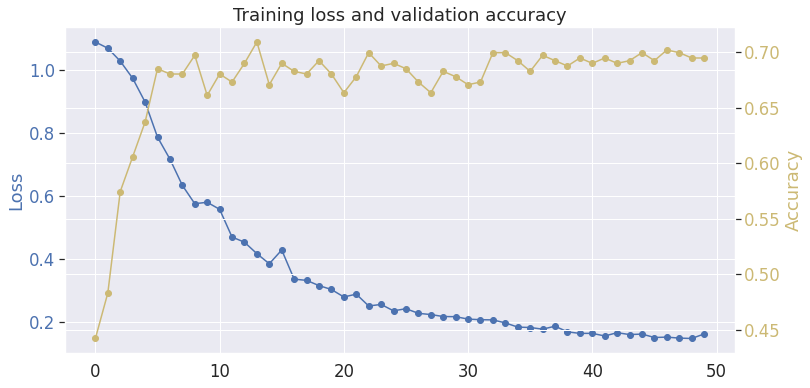

In [ ]:
plot_loss_and_acc(model_eval["train_loss"], model_eval["valid_accs"])

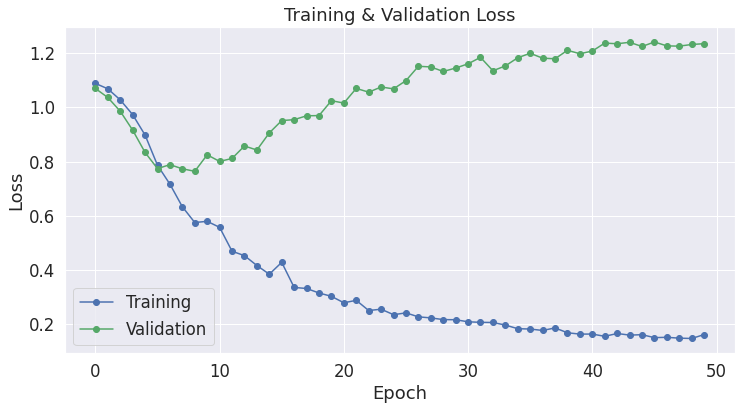

In [ ]:
plot_loss(model_eval["train_loss"], model_eval["valid_loss"])

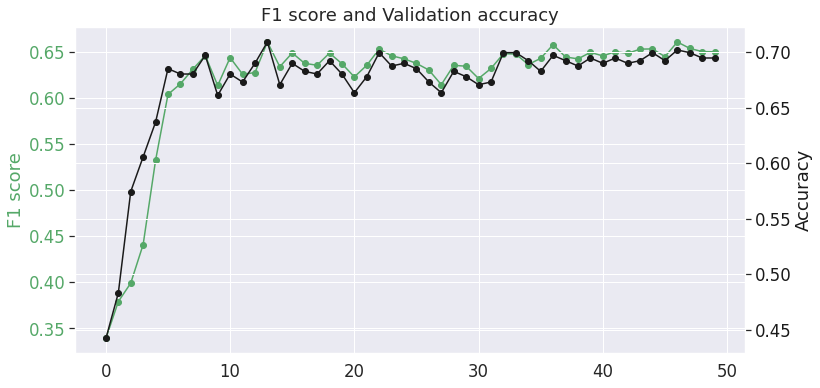

In [ ]:
plot_acc_and_f1(model_eval["valid_accs"], model_eval["f1"])

In [ ]:
def predict(inputs, tokenizer, model):
  with torch.no_grad():
    max_len = max([len(tokenizer(datapoint)['input_ids']) for datapoint in inputs])
    tokenized_inputs = tokenizer(
      inputs.tolist(),          # Input text
      add_special_tokens=True,  # add '[CLS]' and '[SEP]'
      padding='max_length',     # pad to a length specified by the max_length
      max_length=max_len,       # truncate all sentences longer than max_length
      return_tensors='pt',      # return everything we need as PyTorch tensors
    )
    output = model(input_ids = tokenized_inputs['input_ids'])
    output = nn.functional.softmax(output[0]).detach().numpy()
    output = output.argmax(axis = 1)
  return output
